
## Projecció prespectiva

In [177]:
import numpy as np    
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

path = os.listdir('imatges/')
path_img = ['imatges/'+ n for n in path if 'Patro' not in n]
path_patro = 'imatges/Patro.png'

### 1 Read pattern

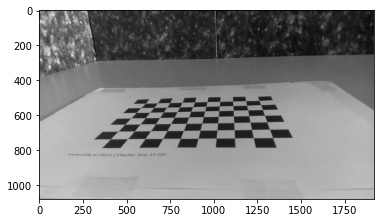

In [158]:
pattern = cv2.imread(path_patro)
pattern_gray =  cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
plt.imshow(pattern_gray, cmap = 'gray')

In [159]:
retval, corners = cv2.findChessboardCorners(pattern_gray, (10, 7), None)

### Subcorners

In [160]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners2 = cv2.cornerSubPix(pattern_gray,corners, (11,11), (-1,-1), criteria)

/tmp/ipykernel_132520/620199504.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


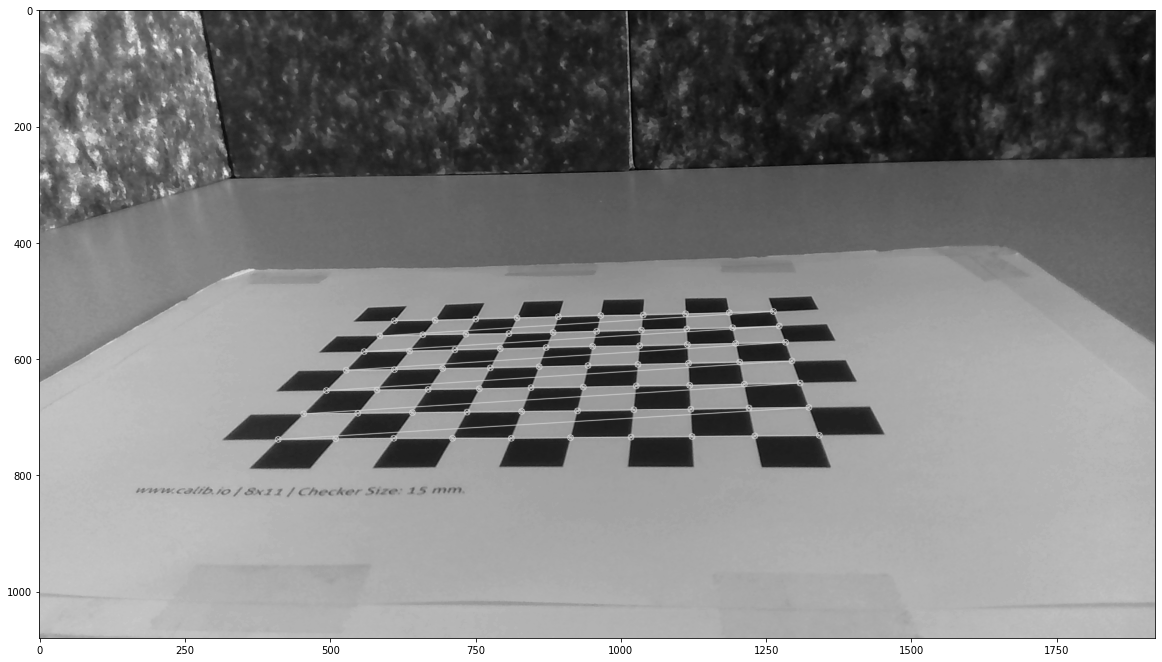

In [161]:
im = cv2.drawChessboardCorners(pattern_gray, (10,7), corners2, retval)

fig = plt.figure(figsize=(20,20))
plt.imshow(im, cmap = 'gray')
fig.show()


### Homography

In [162]:
pattern = cv2.imread(path_patro)
pattern_gray =  cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)

w = int((30 * 9) + (30*9*1.5))
h= int((30*6) + (30*6*1.5))
print(w,h)
x_p = [(30*9*0.75) + 30 * n for n in range(10)]
y_p = [(30*6*0.75) + 30 * n for n in range(7)]

675 450


In [163]:
m = np.zeros_like(corners2)
c = 0
for y in y_p:
    for x in x_p:
        m[c] = np.array([x,y])
        c += 1

In [164]:
h ,status = cv2.findHomography(corners2,m)

In [165]:
im_dst = cv2.warpPerspective(pattern_gray, h, (675,450))

/tmp/ipykernel_132520/4061484973.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


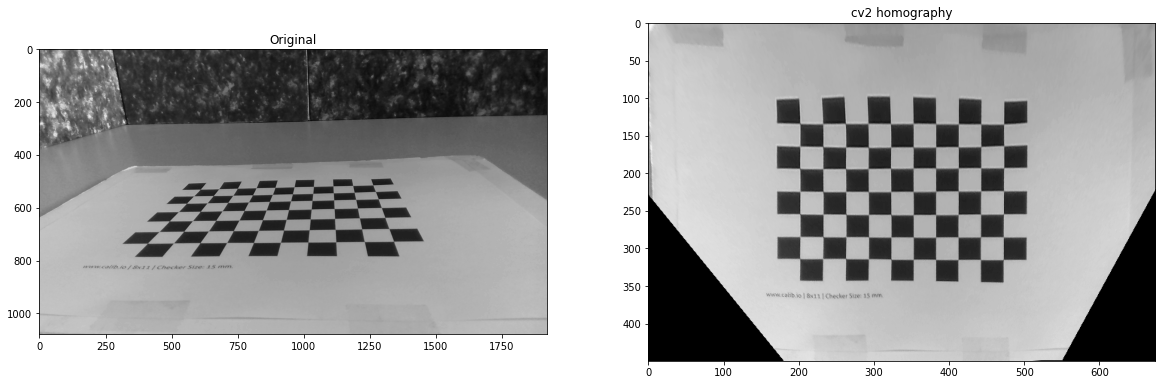

In [166]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (20,20))
ax0.title.set_text('Original')
ax0.imshow(pattern_gray, cmap = 'gray')
ax1.title.set_text('cv2 homography')
ax1.imshow(im_dst, cmap = 'gray')
fig.show()

## 2

In [167]:
A = np.array([(xs, ys, 1, 0, 0 , 0, -xd*xs, -xd*ys, -xd) if (c%2 == 0) else (0, 0, 0, xs, ys , 1, -yd*xs, -yd*ys, -yd)\
    for c, ((xs,ys),(xd,yd)) in enumerate([(a[0],b[0]) for a,b in zip(corners2, m)])])

U, S, C = np.linalg.svd(A)

H = (C[-1,:]/C[-1,-1]).reshape(3,3)

In [168]:
H, h

(array([[-1.97478356e+00, -3.66893633e+00,  2.31683368e+03],
        [-2.05413287e-01, -6.58938985e+00,  3.07853948e+03],
        [-5.22430001e-04, -9.13964053e-03,  1.00000000e+00]]),
 array([[-1.92668419e+00, -3.57424466e+00,  2.26218658e+03],
        [-2.03466263e-01, -6.41759820e+00,  3.00269120e+03],
        [-5.25982022e-04, -8.90827604e-03,  1.00000000e+00]]))

In [169]:
im_dst_2 = cv2.warpPerspective(pattern_gray, H, (675,450))

/tmp/ipykernel_132520/2403548345.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


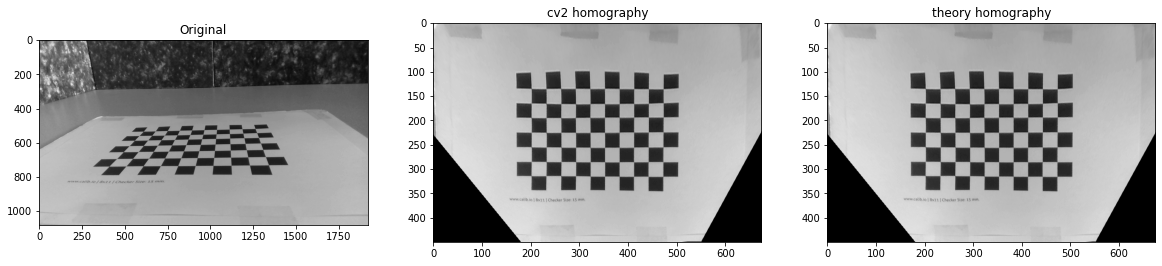

In [170]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (20,20))
ax0.title.set_text('Original')
ax0.imshow(pattern_gray, cmap = 'gray')
ax1.title.set_text('cv2 homography')
ax1.imshow(im_dst, cmap = 'gray')
ax2.title.set_text('theory homography')
ax2.imshow(im_dst_2, cmap = 'gray')
fig.show()

## 3

In [174]:
## trobem el chess board de nou en les imatges amb la homografia
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

retval, corners = cv2.findChessboardCorners(im_dst, (10, 7), None)
corners_h = cv2.cornerSubPix(pattern_gray,corners, (11,11), (-1,-1), criteria)

retval, corners = cv2.findChessboardCorners(im_dst_2, (10, 7), None)
corners_H = cv2.cornerSubPix(pattern_gray,corners, (11,11), (-1,-1), criteria)

In [255]:
def projection_error(points_s, points_d, title):
    df0 = pd.DataFrame({'x': [x[0][0] for x in points_s], 'y': [x[0][1] for x in points_s], 'xy': [x[0] for x in points_s], 'points': 'origin'})
    df1 = pd.DataFrame({'x': [x[0][0] for x in points_d], 'y': [x[0][1] for x in points_d], 'xy': [x[0] for x in points_d], 'points': 'result'})
    data = pd.concat([df0,df1])
    error = np.array([np.sqrt((p1[0][0]-p0[0][0])**2 + (p1[0][1]-p0[0][1])**2) for p1,p0 in zip(corners_h, m)]) / 2
    fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (40,10))
    fig.suptitle(title, fontsize=20)
    ax0.title.set_text('Diferència entre punt original i projectat')
    sns.scatterplot(data = data, x = 'x', y = 'y', hue = 'points', ax = ax0)
    ax1.title.set_text('Boxplot entre punt original i projectat (error en mm)')
    sns.boxplot(data = error, ax = ax1)
    ax2.title.set_text('Histograma del error en mm entre punt original i projectat')
    sns.histplot(data = error, ax = ax2)
    fig.show()
    return 0

/tmp/ipykernel_132520/892573706.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

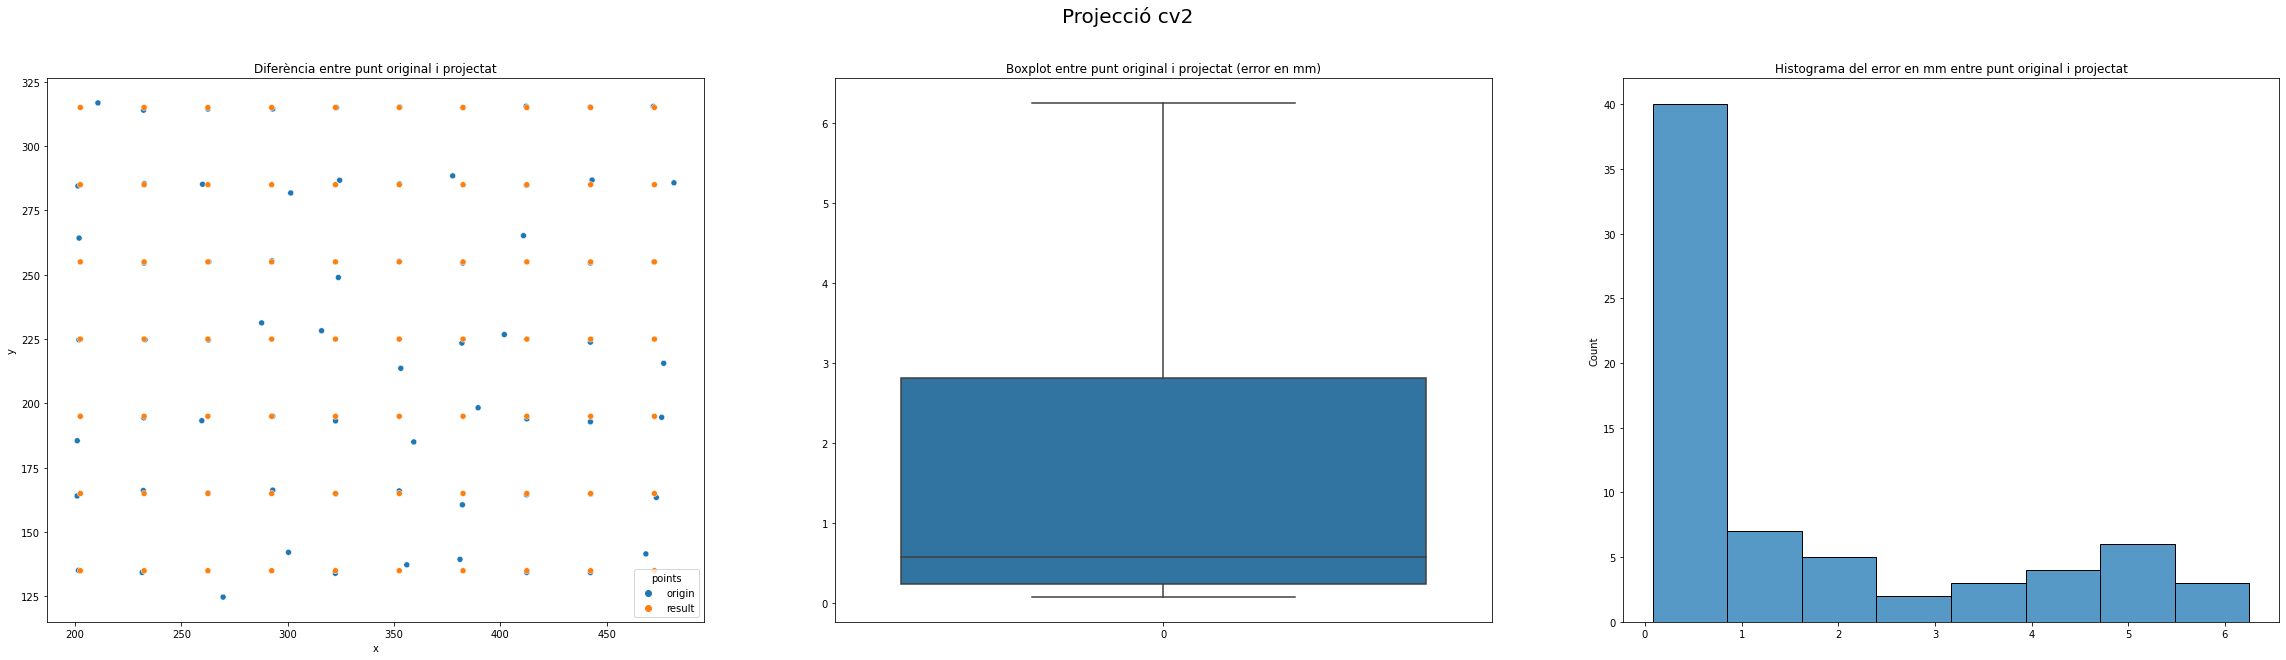

In [256]:
projection_error(corners_h, m, title = 'Projecció cv2')

/tmp/ipykernel_132520/892573706.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0

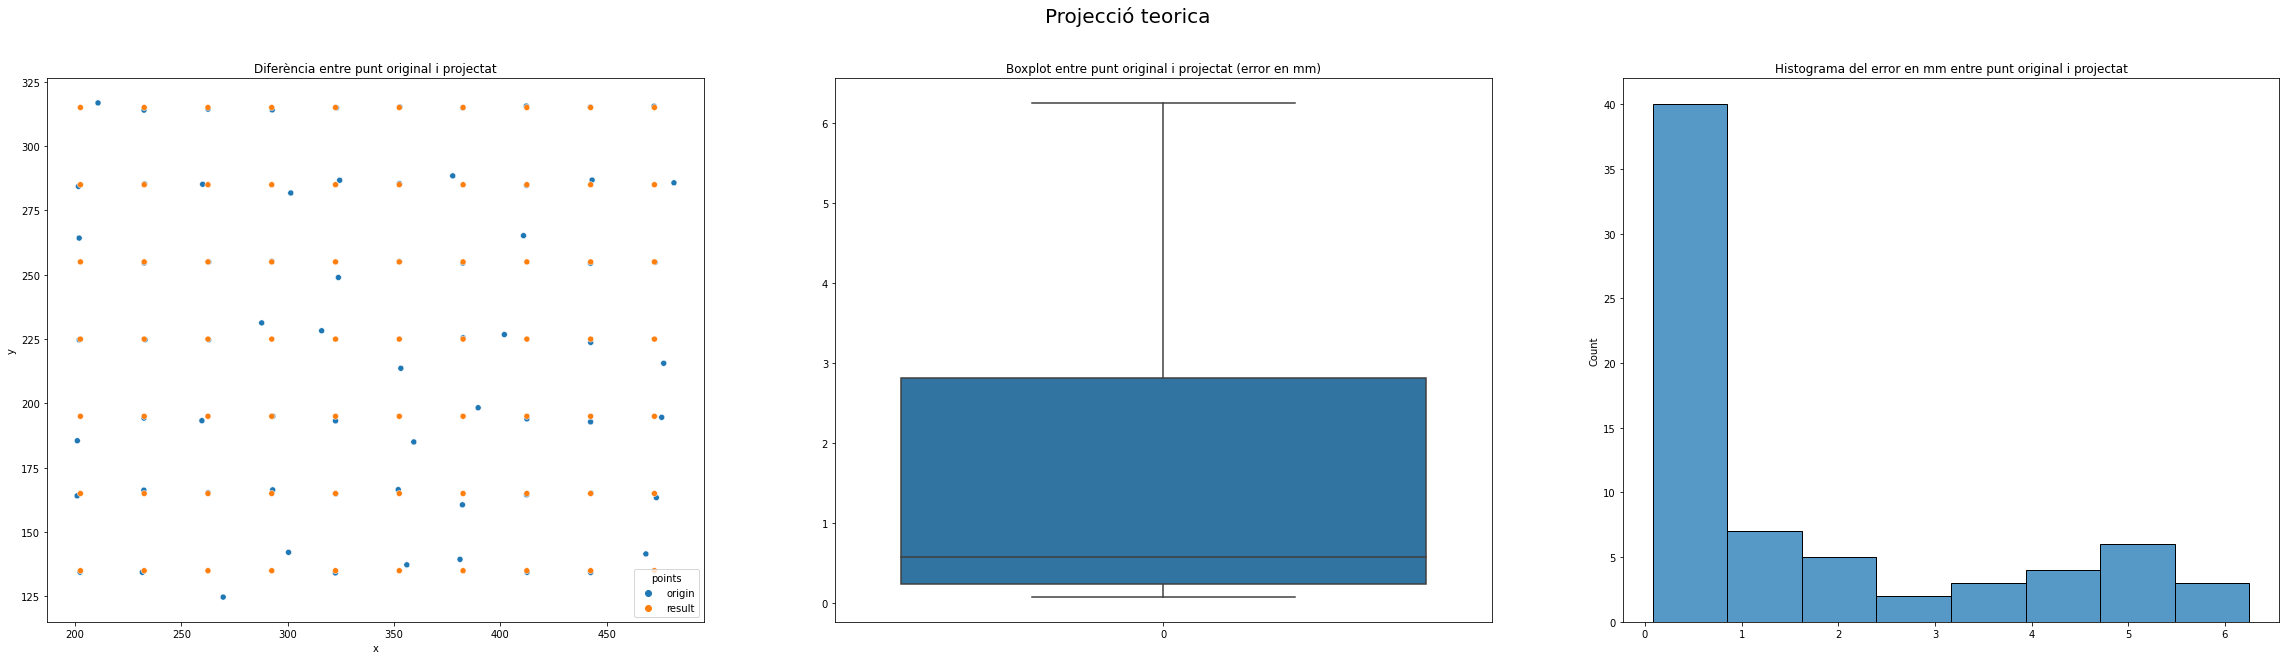

In [257]:
projection_error(corners_H, m, title = 'Projecció teorica')